In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [5]:
from langchain_core.tools import tool
import requests

In [6]:

@tool
def get_places(city: str, query: str = "attractions") -> list:
    """
    Fetches top places (e.g., attractions, restaurants) in a city using the Foursquare Places API
    and returns them as a structured JSON list.

    Parameters:
        city (str): Name of the city (e.g., 'Kolkata')
        query (str): Type of places to search for (e.g., 'attractions', 'museums')

    Returns:
        list: A list of dictionaries, each containing:
            - name: Place name
            - categories: List of category names
            - address: Formatted address
            - phone: Telephone number if available
            - website: Website URL if available
"""
    api_key = os.getenv("FOURSQUARE_API_KEY")
    if not api_key:
        return [{"error": "Missing FOURSQUARE_API_KEY"}]

    url = "https://places-api.foursquare.com/places/search"
    headers = {
        "accept": "application/json",
        "X-Places-Api-Version": "2025-06-17",
        "authorization": api_key
    }
    params = {
        "near": city,
        "query": query,
        "limit": 10
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code != 200:
        return [{"error": f"Foursquare API error: {response.text}"}]

    results = response.json().get("results", [])
    if not results:
        return [{"message": f"No results found for '{query}' in {city}."}]

    extracted = []
    for place in results:
        name = place.get("name", "Unknown")
        categories = [cat.get("name") for cat in place.get("categories", [])]
        address = place['location']['formatted_address']
        phone = place.get("tel", None)
        website = place.get("website", None)

        extracted.append({
            "name": name,
            "categories": categories,
            "address": address,
            "phone": phone,
            "website": website
        })

    return extracted

In [7]:
# get_places.invoke(
#     {
#         "city": "Bangalore",
#         "query": "hotels"
#     }
# )

In [8]:
from datetime import datetime, timedelta

@tool
def get_hotels_by_city(city: str) -> list:
    """
    Get top hotels with prices per night in INR for the given city using Hotels4 (RapidAPI).
    
    Parameters:
        city (str): City name (e.g., "Kolkata")

    Returns:
        list: List of hotels with name, price, and address
    """

    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY"),
        "x-rapidapi-host": "hotels4.p.rapidapi.com"
    }

    # Step 1: Get gaiaId (destination identifier)
    location_url = "https://hotels4.p.rapidapi.com/locations/v3/search"
    location_params = {
        "q": city,
        "locale": "en_US",
        "langid": "1033",
        "siteid": "3000000"
    }

    location_resp = requests.get(location_url, headers=headers, params=location_params)
    if location_resp.status_code != 200:
        return [{"error": f"Location fetch failed: {location_resp.text}"}]

    try:
        gaia_id = location_resp.json()["sr"][0]["gaiaId"]
    except Exception:
        return [{"error": f"Could not find destination ID for city: {city}"}]

    # Step 2: Get hotel list for destination
    hotel_url = "https://hotels4.p.rapidapi.com/properties/v2/list"
    today = datetime.today()

    payload = {
        "currency": "INR",
        "locale": "en_US",
        "siteId": 3000000,
        "destination": {"regionId": gaia_id},
        "checkInDate": {
            "day": today.day,
            "month": today.month,
            "year": today.year
        },
        "checkOutDate": {
            "day": (today + timedelta(days=1)).day,
            "month": (today + timedelta(days=1)).month,
            "year": (today + timedelta(days=1)).year
        },
        "rooms": [{"adults": 1}],
        "resultsStartingIndex": 0,
        "resultsSize": 20,
        # "sort": "PRICE_LOW_TO_HIGH",
        "filters": {}
    }

    hotel_resp = requests.post(hotel_url, json=payload, headers=headers)
    if hotel_resp.status_code != 200:
        return [{"error": f"Hotel list fetch failed: {hotel_resp.text}"}]

    hotels_raw = hotel_resp.json().get("data", {}).get("propertySearch", {}).get("properties", [])
    if not hotels_raw:
        return [{"message": f"No hotel results found in {city}"}]

    results = []
    for hotel in hotels_raw:
        # print(hotel)
        # print('*'*50)
        # print()
        name = hotel.get("name")
        address = hotel.get("address", {}).get("addressLine", "No address provided")
        price = hotel.get("price", {}).get("lead", {}).get("formatted", "N/A")
        results.append({
            "name": name,
            "address": address,
            "price_per_night": price
        })

    return results

In [9]:
# get_hotels_by_city.invoke("Bangalore")

In [10]:
@tool
def convert_currency(amount: float, to_currency: str, base: str = "USD") -> float:
    """
    Convert a monetary amount from one currency to another using real-time exchange rates.

    This function fetches the latest exchange rate between the specified base currency
    and the target currency using the ExchangeRate-API and calculates the converted value.

    Args:
        amount (float): The amount of money to convert.
        to_currency (str): The target currency code (e.g., "EUR", "INR").
        base (str, optional): The source currency code. Defaults to "USD".

    Returns:
        float: The converted amount in the target currency, rounded to two decimal places.
                If the exchange rate is unavailable, returns a dictionary with an error message.

    Example:
        >>> convert_currency(100, "INR")
        8356.25

    Notes:
        - This tool uses the open endpoint from https://open.er-api.com.
        - Ensure that `to_currency` and `base` are valid ISO currency codes.
    """
    url = f"https://open.er-api.com/v6/latest/{base}"
    resp = requests.get(url)
    data = resp.json()
    rate = data["rates"].get(to_currency)
    if not rate:
        return {"error": f"Rate unavailable for {to_currency}"}
    return round(amount * rate, 2)

In [11]:

@tool
def get_flight_fares(from_code: str, to_code: str, date: str, adult: int = 1, type_: str = "economy") -> list:
    """
    Fetches flight fare data using the Flight Fare Search API on RapidAPI.

    Args:
        from_code (str): IATA code of departure airport (e.g., 'BLR')
        to_code (str): IATA code of arrival airport (e.g., 'CCU')
        date (str): Travel date in YYYY-MM-DD
        adult (int): Number of adult passengers (default: 1)
        type_ (str): Cabin class (default: 'economy')

    Returns:
        list: List of flights with key details: timing, pricing, stops, countries, and cabin info.
    """
    url = "https://flight-fare-search.p.rapidapi.com/v2/flights/"

    querystring = {
        "from": from_code,
        "to": to_code,
        "date": date,
        "adult": str(adult),
        "type": type_,
        "currency": "USD"
    }

    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY"),
        "x-rapidapi-host": "flight-fare-search.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    # print("🔍 Raw API response:", response.status_code, response.text)

    try:
        raw = response.json()
        flights = raw.get("results", [])
        if not isinstance(flights, list) or not flights:
            return [{"message": "No flights found."}]

        results = []
        for f in flights:
            stop_info = []
            stop_summary = f.get("stopSummary", {})

            # Extract intermediate stops if present
            if isinstance(stop_summary, dict):
                for key, val in stop_summary.items():
                    if key != "connectingTime" and isinstance(val, dict):
                        stop_info.append({
                            "intermediate_airport": val.get("airport", "Unknown"),
                            "stop_duration_minutes": val.get("stopDuration")
                        })

            results.append({
                "flight_code": f.get("flight_code"),
                "airline": f.get("flight_name"),
                "cabin_type": f.get("cabinType", "Unknown"),
                "stops": f.get("stops", "Unknown"),
                "departure_city": f.get("departureAirport", {}).get("city"),
                "departure_country": f.get("departureAirport", {}).get("country", {}).get("label"),
                "departure_time": f.get("departureAirport", {}).get("time"),
                "arrival_city": f.get("arrivalAirport", {}).get("city"),
                "arrival_country": f.get("arrivalAirport", {}).get("country", {}).get("label"),
                "arrival_time": f.get("arrivalAirport", {}).get("time"),
                "duration": f.get("duration", {}).get("text"),
                "price": f.get("totals", {}).get("total"),
                "currency": f.get("totals", {}).get("currency"),
                "intermediate_stops": stop_info if stop_info else None
            })

        return results

    except Exception as e:
        return [{"error": str(e)}]

In [12]:
@tool
def get_weather(city: str) -> dict:
    """Get detailed current weather data for a city as a dictionary."""
    
    api_key = os.getenv("OPENWEATHER_API_KEY")
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    response = requests.get(url)
    
    if response.status_code != 200:
        return {"error": f"Failed to get weather: {response.text}"}
    
    data = response.json()
    
    return {
        "city": data.get("name"),
        "country": data.get("sys", {}).get("country"),
        "description": data.get("weather", [{}])[0].get("description"),
        "temperature_celsius": data.get("main", {}).get("temp"),
        "feels_like_celsius": data.get("main", {}).get("feels_like"),
        "temp_min": data.get("main", {}).get("temp_min"),
        "temp_max": data.get("main", {}).get("temp_max"),
        "humidity": data.get("main", {}).get("humidity"),
        "pressure": data.get("main", {}).get("pressure"),
        "wind_speed_mps": data.get("wind", {}).get("speed"),
        "wind_deg": data.get("wind", {}).get("deg"),
        "visibility_m": data.get("visibility"),
        "cloud_coverage_percent": data.get("clouds", {}).get("all"),
        "sunrise_utc": data.get("sys", {}).get("sunrise"),
        "sunset_utc": data.get("sys", {}).get("sunset"),
        "icon": data.get("weather", [{}])[0].get("icon")
    }


In [13]:
# get_weather.invoke('kolkata')

In [14]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage

In [15]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000029E6E9CE660>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000029E6F2414C0>, root_client=<openai.OpenAI object at 0x0000029E6ECD7E90>, root_async_client=<openai.AsyncOpenAI object at 0x0000029E6F037B90>, model_name='gpt-4o-mini', temperature=0.3, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [16]:
tools = [
    get_places, 
    get_hotels_by_city, 
    get_flight_fares, 
    convert_currency, 
    get_weather, 
    DuckDuckGoSearchRun(), 
    TavilySearchResults()
]

llm_with_tools = llm.bind_tools(tools)
llm_with_tools

C:\Users\Bapan Bairagya\AppData\Local\Temp\ipykernel_18592\660601956.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  TavilySearchResults()


RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000029E6E9CE660>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000029E6F2414C0>, root_client=<openai.OpenAI object at 0x0000029E6ECD7E90>, root_async_client=<openai.AsyncOpenAI object at 0x0000029E6F037B90>, model_name='gpt-4o-mini', temperature=0.3, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_places', 'description': "Fetches top places (e.g., attractions, restaurants) in a city using the Foursquare Places API\nand returns them as a structured JSON list.\n\nParameters:\n    city (str): Name of the city (e.g., 'Kolkata')\n    query (str): Type of places to search for (e.g., 'attractions', 'museums')\n\nReturns:\n    list: A list of dictionaries, each containing:\n        - name: Place name\n        - categories: List of category names\n        - address: 

In [17]:
from langchain_core.messages import SystemMessage

TOOL_EDUCATION_SYSTEM_MESSAGE = SystemMessage(content="""
You are an AI-powered travel planning assistant. You have access to a set of real-time tools. 
Always prefer calling these tools over using your internal knowledge, especially for up-to-date or location-specific information.

Here’s when to use each tool:

🧭 get_places(city, query):
- Use to find top attractions, restaurants, or activities in any city.

🏨 get_hotels_by_city(city):
- Use to fetch real-time hotel listings and price per night in INR.

✈️ get_flight_fares(from_code, to_code, date):
- Use to find real-time flight fares between two cities for a specific date, including layover details if needed.

💱 convert_currency(amount, to_currency, base):
- Use this for ALL currency conversions. Do NOT estimate exchange rates yourself — always use this tool.

🌦 get_weather(city):
- Use to get the current weather and temperature for any city.

🔍 DuckDuckGoSearchRun and TavilySearchResults:
- Use either tool to find current news, safety alerts, conflicts, events, or cultural activities happening in a city.

Your goal is to generate a complete travel plan using the above tools. Prioritize safety, real-time accuracy, and completeness.
""")


def call_llm_with_tool_bind(state: MessagesState) -> dict:
    original_msgs = state["messages"]
    messages = [TOOL_EDUCATION_SYSTEM_MESSAGE] + original_msgs
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

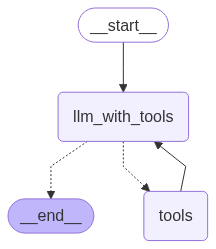

In [18]:
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(MessagesState)
workflow.add_node("llm_with_tools", call_llm_with_tool_bind)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_with_tools")
workflow.add_conditional_edges("llm_with_tools", tools_condition)
workflow.add_edge("tools", "llm_with_tools")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [19]:
events = app.stream(
    {
        "messages": [HumanMessage(content="""
                                    I'm traveling to Paris this weekend. Give me a details summary of what are attractive places in paris and what need to be my budget for this entire trip including hotel price and flight fares?
                                    I will travelling from Bangalore, on July 5, 2025 and my trip duration expected to be 5 days. 
                                    Give all price break down in INR with details analysis. And what about the current weather there? is this a suitable season as a tourist to do a trip there?
                                    Is there any internal conflicts going on there? as a tourist I'm very much aware on my safety.
                                    It's fine if there are no direct flights available from Bangalore to Paris; however, in that case, please provide a price breakdown analysis for a layover journey.
                                    """)]
    },
    config={"configurable": {"thread_id": "demo"}},
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================


                                    I'm traveling to Paris this weekend. Give me a details summary of what are attractive places in paris and what need to be my budget for this entire trip including hotel price and flight fares?
                                    I will travelling from Bangalore, on July 5, 2025 and my trip duration expected to be 5 days. 
                                    Give all price break down in INR with details analysis. And what about the current weather there? is this a suitable season as a tourist to do a trip there?
                                    Is there any internal conflicts going on there? as a tourist I'm very much aware on my safety.
                                    It's fine if there are no direct flights available from Bangalore to Paris; however, in that case, please provide a price breakdown analysis for a layover journey.
                                 